
# PINN 算例-Helmholtz 方程求解

本节将引导您使用 FEALPy 完成 Helmholtz 方程的 PINN 求解，现定义如下数学模型：

$$
\begin{cases}
-\Delta u - k^2 u = f & \text{在 } \Omega = [0,1]^2 \\
\frac{\partial u}{\partial n} + iku = g & \text{在 } \partial \Omega
\end{cases}
$$

其中我们定义真解为：

$$
u(x, y) = e^{ik\beta y}e^{-k\sqrt{\beta^2-1}(x+1)} \\
\text{其中 },~i~是虚数单位，~k~是波数,~\beta~是无量纲传播参数（\beta > 1）。
$$



源项为：

$$
f(x,y) = 0
$$


### 1. 定义 PDE 模型

In [1]:
import math
from fealpy.backend import backend_manager as bm
from fealpy.decorator import cartesian

# 方程的常数项
k = 1.0
beta = 1.001
gamma = math.sqrt(beta**2 - 1.0)

# 定义域
def domain():
    return [0.0, 1.0, 0.0, 1.0]

# 真解
@cartesian
def solution(p):
    x = p[..., 0]
    y = p[..., 1]
    val = bm.exp(1j * beta * k * y) * bm.exp(-k * gamma * (x + 1.0))
    return val

# 源项
@cartesian
def source(p):
    val =bm.zeros_like(p[..., 0], dtype=bm.complex128)
    return val

# 梯度
@cartesian
def gradient(p):
    
    u = solution(p)
    du_dx = -k * gamma * u
    du_dy = 1j * beta * k * u
    val = bm.stack((du_dx, du_dy), axis=-1)
    return val

# dirichlet 边界条件
@cartesian
def robin(p, n):
    kappa = 1j * k
    grad = gradient(p)
    val = bm.sum(grad * n, axis=-1)
    val += kappa * solution(p)
    return val

### 2. 进行参数配置和初始化

设置后端

In [2]:
from fealpy.backend import backend_manager as bm

backend = 'pytorch'
device = 'cpu'
bm.set_backend(backend)

导入日志工具

In [3]:
from fealpy.utils import timer
from fealpy import logger

logger.setLevel('WARNING')
tmr = timer()
next(tmr)

设置网格和采样器

In [4]:
from fealpy.mesh import TriangleMesh
from fealpy.ml.sampler import ISampler, BoxBoundarySampler

domain = domain()

mesh = TriangleMesh.from_box(domain, nx=30, ny=30)

sampler_pde = ISampler(ranges=domain, mode="random", requires_grad=True)
sampler_bc = BoxBoundarySampler(domain, mode="random", requires_grad=True)


设置超参数

In [5]:
npde = 400
nbc = 100
lr = 0.01
epochs = 1000
weight = [1, 30]

设置网络、优化器、学习率调度器、损失函数

In [6]:
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from fealpy.ml.modules import Solution

net0 = nn.Sequential(
        nn.Linear(2, 64, dtype=bm.float64),
        nn.Tanh(),
        nn.Linear(64, 32, dtype=bm.float64),
        nn.Tanh(),
        nn.Linear(32, 16, dtype=bm.float64),
        nn.Tanh(),
        nn.Linear(16, 2, dtype=bm.float64))
net = Solution(net0, complex=True)

optim = Adam(net.parameters(), lr=lr, betas=(0.9, 0.99))
steplr = StepLR(optim, step_size=500, gamma=0.1)

mse = nn.MSELoss(reduction='mean')


### 3.定义残差函数

定义区域内部的残差函数

In [7]:
def pde_residual(p):
    from fealpy.ml import gradient
    u = net(p)
    f = source(p).flatten()    

    laplacian = bm.zeros(u.shape[0], dtype=bm.complex128)   
    grad_u = gradient(u.real, p, create_graph=True)  
    grad_u_imag = gradient(u.imag, p, create_graph=True)

    for i in range(p.shape[-1]):
        u_ii = gradient(grad_u[..., i], p, create_graph=True, split=True)[i]  
        u_jj = gradient(grad_u_imag[..., i], p, create_graph=True, split=True)[i]  
        laplacian += u_ii.flatten() + 1j * u_jj.flatten()
    
    assert f.shape == laplacian.shape, f"Shape mismatch: f.shape={f.shape}, laplacian.shape={laplacian.shape}."

    val = laplacian + k**2 * u.flatten() + f
    return val

定义求边界点法向量的函数

In [8]:
def set_n(p):
    n = bm.zeros_like(p)
    tol = 1e-4
    dim = int(len(domain) / 2)
    coords = [p[..., i] for i in range(dim)]  
    
    for axis in range(dim):
        min_val, max_val = domain[2*axis], domain[2*axis+1]
        min_mask = bm.abs(coords[axis] - min_val) <= tol
        max_mask = bm.abs(coords[axis] - max_val) <= tol

        if axis == 0:
            active_mask = bm.ones_like(min_mask, dtype=bool)
        else:
            active_mask = ~bm.any(n != 0, axis=-1)
        
        n[min_mask & active_mask, axis] = -1.0  # 负向边界
        n[max_mask & active_mask, axis] = 1.0   # 正向边界
    
    return n

定义区域边界的残差函数

In [9]:
def bc_residual(p):
    from fealpy.ml import gradient
    u = net(p)
    n = set_n(p)
    
    grad_u_real = gradient(u.real, p, create_graph=True, split=False)
    grad_u_imag = gradient(u.imag, p, create_graph=True, split=False)
    grad_u = grad_u_real + 1j * grad_u_imag

    kappa = bm.tensor(0.0 + 1j * k)
    g = robin(p=p, n=n)

    return (grad_u*n).sum(dim=-1) + kappa * u.flatten() - g.flatten()


### 4. 训练网络

In [10]:
# 训练过程
next(tmr)
Loss = []
Error_real = []
Error_imag = []

for epoch in range(epochs+1):

    optim.zero_grad()

    spde = sampler_pde.run(npde)
    sbc = sampler_bc.run(nbc, nbc)

    pde_res = pde_residual(spde)
    bc_res = bc_residual(sbc)

    pde_r = pde_res.real
    bc_r = bc_res.real
    mse_pde_r = mse(pde_r, bm.zeros_like(pde_r))
    mse_bc_r = mse(bc_r, bm.zeros_like(bc_r))

    pde_i =  bm.imag(pde_res)
    bc_i = bm.imag(bc_res)
    mse_pde_i = mse(pde_i, bm.zeros_like(pde_i))
    mse_bc_i = mse(bc_i, bm.zeros_like(bc_i))

    # 总损失函数
    loss = weight[0] * (mse_pde_r + mse_pde_i) + weight[1] *(0.5* mse_bc_r + 0.5 * mse_bc_i)
    
    loss.backward(retain_graph=True)
    optim.step()
    steplr.step()
    if epoch % 50 == 0:
        error_real = net.estimate_error(solution, mesh, coordtype='c', compare="real")
        error_imag = net.estimate_error(solution, mesh, coordtype='c', compare="imag")

        Error_real.append(error_real.item())
        Error_imag.append(error_imag.item())

        Loss.append(loss.item())

        print(f"Epoch: {epoch}, Loss: {loss.item():.6f}, Error_real:{error_real.item():.6f}, Error_imag:{error_imag.item():.6f}\n")
tmr.send(f'PINN training time')
next(tmr)


Timer received None and paused.
   ID       Time        Proportion(%)    Label
-------------------------------------------------
Epoch: 0, Loss: 14.663763, Error_real:0.392320, Error_imag:0.162888

Epoch: 50, Loss: 0.019208, Error_real:0.012937, Error_imag:0.017321

Epoch: 100, Loss: 0.002252, Error_real:0.001387, Error_imag:0.002436

Epoch: 150, Loss: 0.002810, Error_real:0.007548, Error_imag:0.008030

Epoch: 200, Loss: 0.001581, Error_real:0.004311, Error_imag:0.004147

Epoch: 250, Loss: 0.000791, Error_real:0.003243, Error_imag:0.002879

Epoch: 300, Loss: 0.006092, Error_real:0.010763, Error_imag:0.011011

Epoch: 350, Loss: 0.000461, Error_real:0.000344, Error_imag:0.000583

Epoch: 400, Loss: 0.000406, Error_real:0.000975, Error_imag:0.000483

Epoch: 450, Loss: 0.000329, Error_real:0.000285, Error_imag:0.000598

Epoch: 500, Loss: 0.000808, Error_real:0.002091, Error_imag:0.003292

Epoch: 550, Loss: 0.000127, Error_real:0.000269, Error_imag:0.000130

Epoch: 600, Loss: 0.000102, Error

### 5. 结果可视化


损失曲线、误差曲线

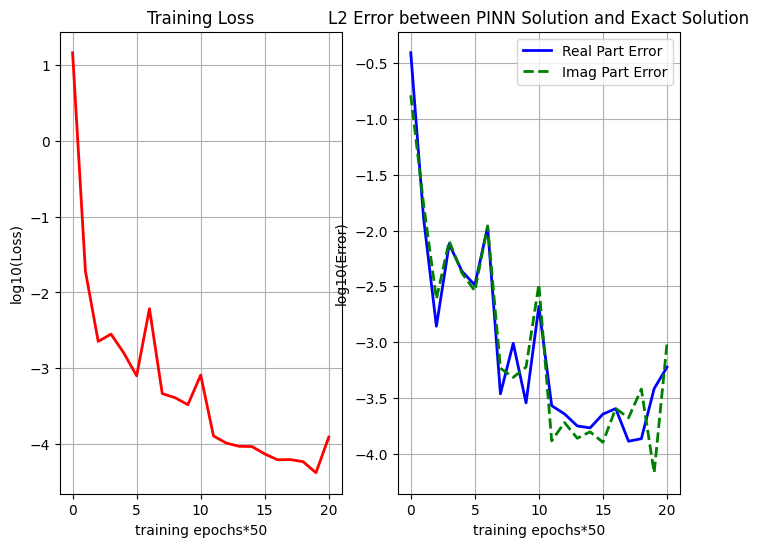

In [11]:
from matplotlib import pyplot as plt
# Loss = []
# Error_real = []
# Error_imag = []
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
Loss = bm.log10(bm.tensor(Loss)).numpy()

# 绘制损失曲线
axes[0].plot(Loss, 'r-', linewidth=2)
axes[0].set_title('Training Loss', fontsize=12)
axes[0].set_xlabel('training epochs*50', fontsize=10)
axes[0].set_ylabel('log10(Loss)', fontsize=10)
axes[0].grid(True)

# 绘制实部和虚部误差曲线
error_real = bm.log10(bm.tensor(Error_real)).numpy()
error_imag = bm.log10(bm.tensor(Error_imag)).numpy()
axes[1].plot(error_real, 'b-', linewidth=2, label='Real Part Error')
axes[1].plot(error_imag, 'g--', linewidth=2, label='Imag Part Error')
axes[1].set_title('L2 Error between PINN Solution and Exact Solution', fontsize=12)
axes[1].set_ylabel('log10(Error)', fontsize=10)
axes[1].set_xlabel('training epochs*50', fontsize=10)
axes[1].grid(True)
axes[1].legend()
plt.show()

在网格节点处计算真解和数值解，并进行可视化比较

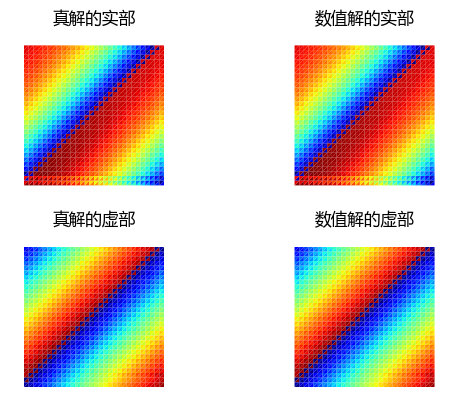

In [12]:
bc = bm.array([[1/3, 1/3, 1/3]], dtype=bm.float64)
# ps = mesh.bc_to_point(bc)
ps = mesh.entity("node")
u = solution(ps).detach().numpy()
uh0 = net(ps).detach().numpy()

fig, axes = plt.subplots(2, 2)
mesh.add_plot(axes[0, 0], cellcolor=u.real, linewidths=0)
axes[0, 0].set_title('真解的实部', fontname='Microsoft YaHei')
mesh.add_plot(axes[0, 1], cellcolor=uh0.real, linewidths=0)
axes[0, 1].set_title('数值解的实部', fontname='Microsoft YaHei')
mesh.add_plot(axes[1, 0], cellcolor=u.imag, linewidths=0)
axes[1, 0].set_title('真解的虚部', fontname='Microsoft YaHei')
mesh.add_plot(axes[1, 1], cellcolor=uh0.imag, linewidths=0)
axes[1, 1].set_title('数值解的虚部', fontname='Microsoft YaHei')
plt.show()
